# Part 1: Wrangling

In [30]:
import sqlite3
import pandas
# Set up connection to database
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

## Problem 1

In [31]:
# SQL code
relation_query = \
"SELECT Salaries.yearID as s_yearID, Salaries.teamID as s_teamID,\
Teams.teamID as t_teamID, Teams.yearID as t_yearID, \
sum(salary) as total_payroll, (W * 100.0/G) as win_percentage \
FROM Teams INNER JOIN Salaries \
ON Teams.yearID = Salaries.yearID AND Teams.teamID = Salaries.teamID \
GROUP BY Salaries.yearID, Salaries.teamID, Teams.teamID, Teams.yearID"

In [32]:
# processing SQL Query using read_sql
df = pandas.read_sql(relation_query, conn) 
df

,s_yearID,s_teamID,t_teamID,t_yearID,total_payroll,win_percentage
0,1985,ATL,ATL,1985,14807000.0,40.740741
1,1985,BAL,BAL,1985,11560712.0,51.552795
2,1985,BOS,BOS,1985,10897560.0,49.693252
3,1985,CAL,CAL,1985,14427894.0,55.555556
4,1985,CHA,CHA,1985,9846178.0,52.147239
...,...,...,...,...,...,...
853,2014,SLN,SLN,2014,120693000.0,55.555556
854,2014,TBA,TBA,2014,72689100.0,47.530864
855,2014,TEX,TEX,2014,112255059.0,41.358025
856,2014,TOR,TOR,2014,109920100.0,51.234568


### Code Description
My code uses the following SQL code
```
    SELECT Salaries.yearID as s_yearID, 
    Salaries.teamID as s_teamID,
    Teams.teamID as t_teamID, 
    Teams.yearID as t_yearID, 
    sum(salary) as total_payroll, 
    W * 100.0/G) as win_percentage 
    FROM Teams INNER JOIN Salaries 
    ON Teams.yearID = Salaries.yearID AND Teams.teamID = Salaries.teamID 
    GROUP BY Salaries.yearID, Salaries.teamID, Teams.teamID, Teams.yearID
```
which uses an INNER join because there seems to be some team and year data that are missing in the salaries table but present in the teams table and vice versa, as shown below:

In [33]:
""" 
    'Left joining' teams table with salaries table to show that some
    data corresponding to a team and year in the Teams table isn't
    found in the Salaries table 
    (so s_yearID, s_teamID, and total_payroll will be true)
"""
temp_df = pandas.read_sql(
    "SELECT Salaries.yearID as s_yearID, Salaries.teamID as s_teamID,\
    Teams.teamID as t_teamID, Teams.yearID as t_yearID, \
    sum(salary)  as total_payroll, (W * 100.0/G) as win_percentage \
    FROM Teams LEFT JOIN Salaries \
    ON Teams.yearID = Salaries.yearID AND Teams.teamID = Salaries.teamID \
    GROUP BY Salaries.yearID, Salaries.teamID, Teams.teamID, Teams.yearID",
    conn)
temp_df.isna().any()

s_yearID           True
s_teamID           True
t_teamID          False
t_yearID          False
total_payroll      True
win_percentage    False
dtype: bool

In [34]:
""" 
    Likewise, 'left joining' salaries table with teams table 
    to show that some data corresponding to a team and year 
    in the salaries table isn't found in the teams table
    (so t_yearID, t_teamID, and win_percentage will be true).
"""
temp_df = pandas.read_sql(
    "SELECT Salaries.yearID as s_yearID, Salaries.teamID as s_teamID,\
    Teams.teamID as t_teamID, Teams.yearID as t_yearID, \
    sum(salary) as total_payroll, (W * 100.0/G) as win_percentage \
    FROM Salaries LEFT JOIN Teams \
    ON Teams.yearID = Salaries.yearID AND Teams.teamID = Salaries.teamID \
    GROUP BY Salaries.yearID, Salaries.teamID, Teams.teamID, Teams.yearID", 
    conn)
temp_df.isna().any()

s_yearID          False
s_teamID          False
t_teamID           True
t_yearID           True
total_payroll     False
win_percentage     True
dtype: bool

INNER JOIN deals with this missing data by focusing on the data for each team and year combination that is found in both tables, as shown below:

In [35]:
"""
    Since INNER JOIN focuses only on the data for
    each team and year combination that is found in both tables, 
    the following should both print only True values
"""
print((df["s_teamID"] == df["t_teamID"]).unique())
print((df["s_yearID"] == df["t_yearID"]).unique())

[ True]
[ True]


In [36]:
# that means I can just have one team ID column and one year ID column 
df = df.rename(columns = {"s_teamID":"teamID", "s_yearID": "yearID"})
df = df.drop(columns = ["t_teamID", "t_yearID"])
df

,yearID,teamID,total_payroll,win_percentage
0,1985,ATL,14807000.0,40.740741
1,1985,BAL,11560712.0,51.552795
2,1985,BOS,10897560.0,49.693252
3,1985,CAL,14427894.0,55.555556
4,1985,CHA,9846178.0,52.147239
...,...,...,...,...
853,2014,SLN,120693000.0,55.555556
854,2014,TBA,72689100.0,47.530864
855,2014,TEX,112255059.0,41.358025
856,2014,TOR,109920100.0,51.234568


# Part 2: Exploratory Data Analysis
## Problem 2 (8 pts)


In [37]:
# importing necessary libraries 
import matplotlib.pyplot as plt
from random import uniform

In [38]:
# limiting the dataframe to only the 1990 - 2014 period for the rest of the project
df = df[df["yearID"].apply(lambda x : x <= 2014 and x >= 1990)]

Text(0.5, 0.98, 'Distribution of all payrolls (1990-2014)')

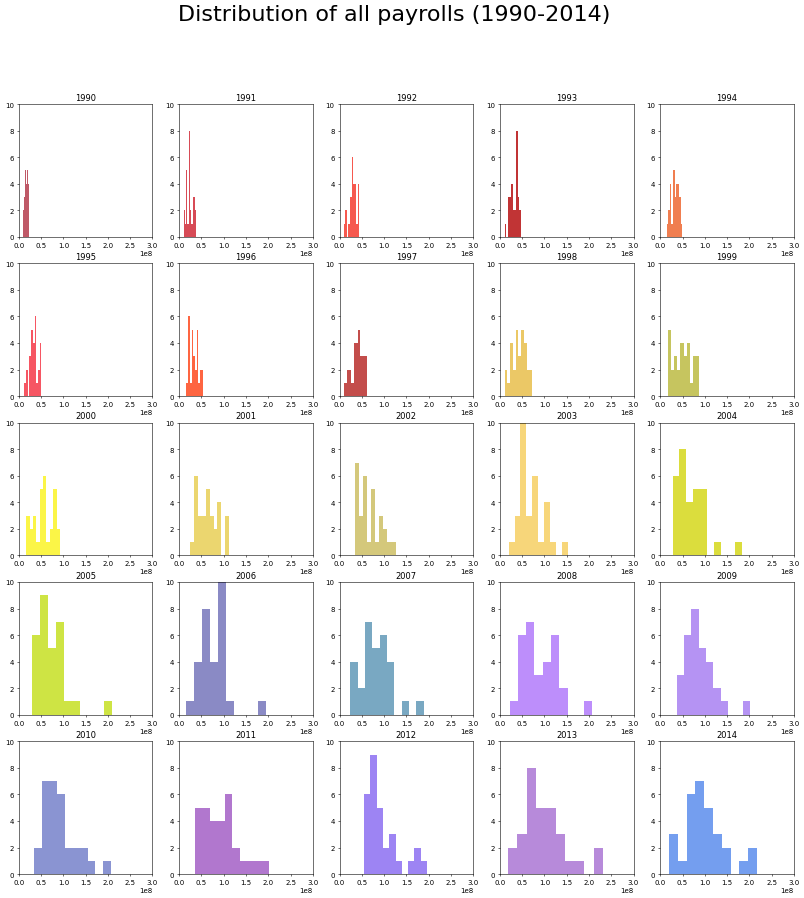

In [39]:
""" 
    Plots a distribution of payrolls across all teams for each year
    in the 1990 - 2014 time period (payroll = x-axis, frequency = y-axis).
"""
fig, axs = plt.subplots(5, 5, figsize = (20, 20), dpi = 50)

# layout all plots as a square matrix
for r in range(0, 5):
    for col in range(0, 5):
        year = 1990 + r * 5 + col
        # pick a color, c, semi-randomly
        if (year <= 1997): c = tuple([uniform(0.75, 1), uniform(0.2, 0.5), uniform(0.2, 0.5)]) # red-orange range
        elif (year <= 2005): c = tuple([uniform(0.75, 1), uniform(0.75, 1), uniform(0.2, 0.5)]) # yellow-green range
        else: c = tuple([uniform(0.4, 0.75), uniform(0.4, 0.75), uniform(0.75, 1)]) # blue-purple range
        
        # plot distribution
        axs[r][col].hist(df[df["yearID"] == year]["total_payroll"], color = c)
        axs[r][col].set_title(year)
        
        # IMPORTANT: ensures that the axes scales are the same for all plots
        axs[r][col].set_xlim([0,3e8])
        axs[r][col].set_ylim([0,10])

fig.suptitle("Distribution of all payrolls (1990-2014)", fontsize=32)

### Code Description
My code plots a distribution of payrolls of all teams for each year in the 1990 - 2014 time period as a histogram (total payroll is plotted along x-axis, the frequency along the y-axis). The plots are laid out in a square matrix form, with the 1990 distribution being in the top left and the 2014 distribution being in the top right. 

## Question 1
Initially, in 1990, the distribution seems to be very clustered but over time, it's become much more spread out from its median payroll (as will be shown in problem 3). The central tendency, namely the median and average payrolls, also seem to be increasing over time. 

## Problem 3

/tmp/ipykernel_55965/1825421652.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs.scatter(range(1990, 2015), df.groupby(by = "yearID").std()["total_payroll"])


Text(0, 0.5, 'Standard Deviation')

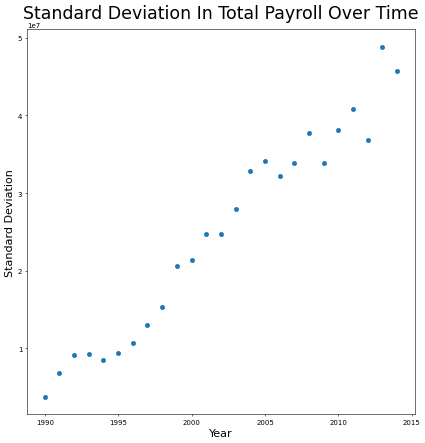

In [40]:
""" 
    Gets the std in total payroll for each year using groupby then
    plots a scatter plot of them with respect to its year 
    (year = x-axis, std = y-axis)
"""
fig, axs = plt.subplots(1, 1 , figsize = (10, 10), dpi = 50)
axs.scatter(range(1990, 2015), df.groupby(by = "yearID").std()["total_payroll"])
axs.set_title("Standard Deviation In Total Payroll Over Time", fontsize=25)
axs.set_xlabel("Year", fontsize=16)
axs.set_ylabel("Standard Deviation", fontsize=16)

### Code Description
The above code gets the standard deviation in total payroll for each year using df.groupby then plots each standard deviation with respect to its year with year on the x-axis and standard deviation on the y-axis.

## Problem 4


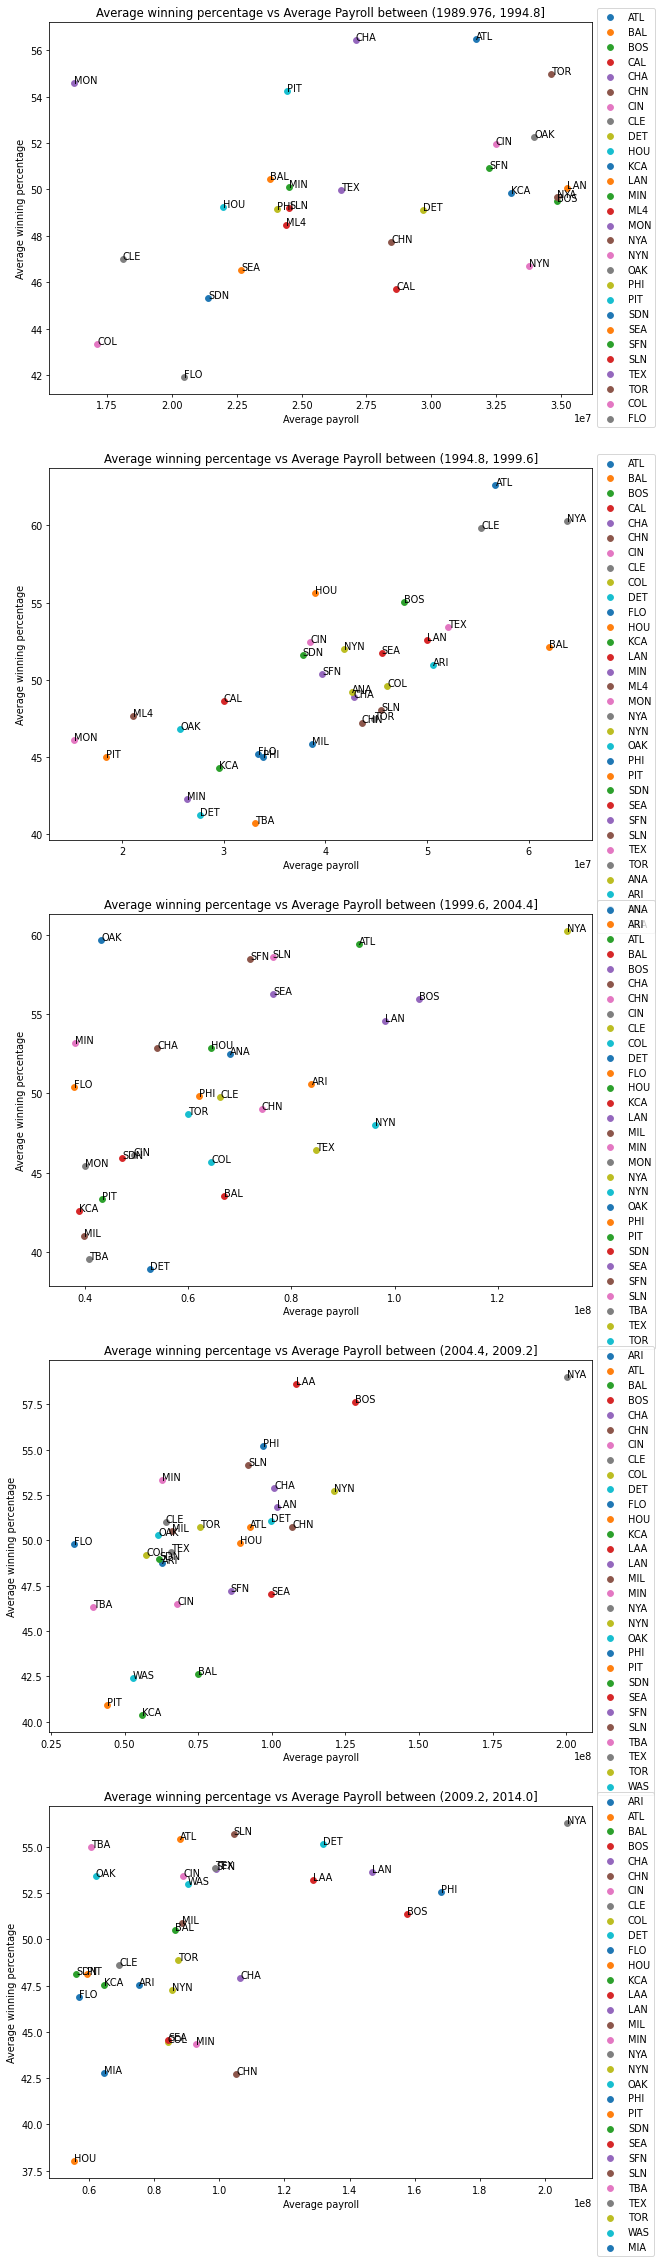

In [41]:
fig, axs = plt.subplots(5, 1 , figsize = (10, 40), dpi = 70)
time_periods = pandas.cut(df["yearID"], 5) 
periods_list = time_periods.unique()
    
for i in range(len(periods_list)):
    cur_df = df[time_periods == periods_list[i]] # dataframe of only the current time period

    # plot for each team (a unique color used for each)
    for team in cur_df["teamID"].unique():
        cur_team_df = cur_df[cur_df["teamID"] == team] # dataframe of a specific team from the period
        axs[i].scatter(cur_team_df["total_payroll"].mean(), cur_team_df["win_percentage"].mean(), label = team)
        axs[i].annotate(team, (cur_team_df["total_payroll"].mean(), cur_team_df["win_percentage"].mean()))
    
    # graph settings
    axs[i].legend(bbox_to_anchor=(1.0, 1.05))
    axs[i].set_title("Average winning percentage vs Average Payroll between " + str(periods_list[i]))
    axs[i].set_xlabel("Average payroll")
    axs[i].set_ylabel("Average winning percentage")
   

### Code Description
The above code uses pandas.cut to figure out which time period each data belongs to then plots 5 different scatterplots for the 5 time periods respectively, plotting the average payroll along the x-axis and the average winning percentage along the y-axis within that time period for each team with a unique color.

## Question 2

Across these periods, more payroll seems to be invested over time from tens of millions of dollars to hundreds of millions of dollars as teams try to increase their winning percentage.Team ATL seems to standout as being particularly good at paying for wins across these time periods. Although their payroll was quite high compared to other teams in the first two time periods, they were able to maintain an average payroll under a hundred million dollars and an average winning percentage of 50% or higher across these time periods. NYA also seems to be able to maintain a winning percentage significantly above 50% albeit with high payroll.

Oakland A's spending efficiency seems to be the best in the period between 2000 and 2005 (the Moneyball period!) but decent otherwise. 

## Problem 5

In [42]:
yearly_stats = df.groupby(by="yearID").describe()["total_payroll"]
std_col = pandas.Series(dtype=float)
for year in range(1990, 2015): 
    std_col = pandas.concat(
       [std_col,  df.loc[df["yearID"] ==  year,"total_payroll"].apply(lambda x : (x - yearly_stats.loc[year, "mean"])/(yearly_stats.loc[year, "std"]))]
    )
df["standardized_payroll"] = std_col

/tmp/ipykernel_55965/96538838.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["standardized_payroll"] = std_col


### Code Description
The above code gets the summary statistics by yearID to get the average payroll and standard deviation of the payroll for the corresponding year of each team using group by. It then iterates through each year, getting each team's payroll for that year and standardizing it. As it does so, there's a running series variable which is updated as each 

## Problem 6

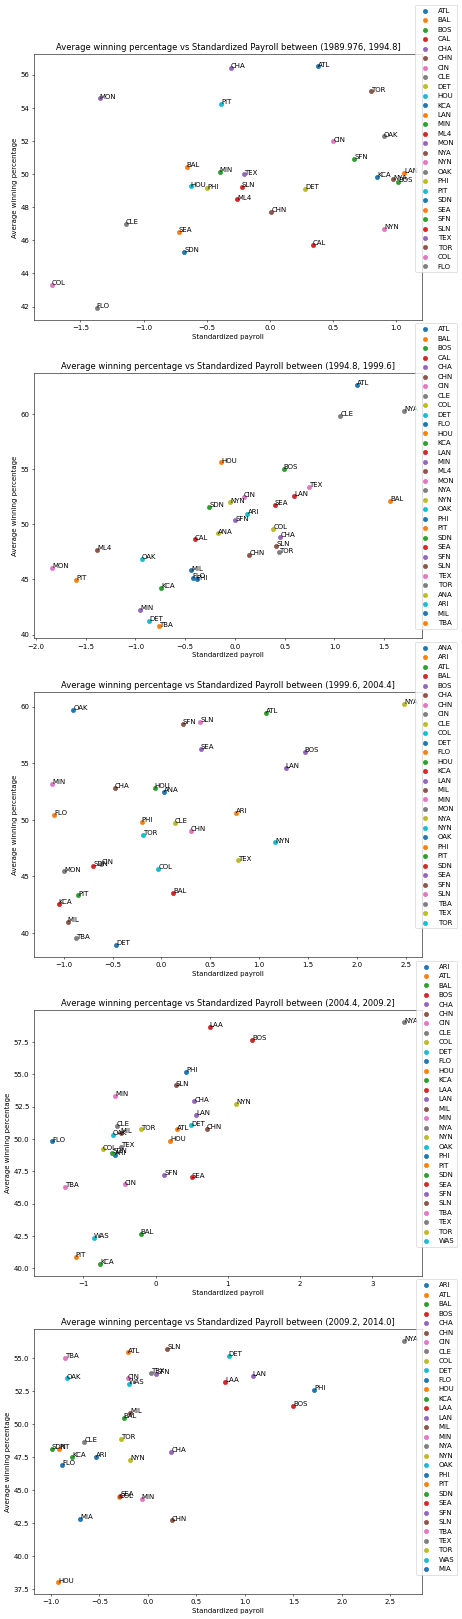

In [43]:
fig, axs = plt.subplots(5, 1 , figsize = (10, 40), dpi = 50)
for i in range(len(periods_list)):
    cur_df = df[time_periods == periods_list[i]]
    
    # plotting the efficiency and the average winning percentage for each team 
    for team in cur_df["teamID"].unique():
        cur_team_df = cur_df[cur_df["teamID"] == team]
        axs[i].scatter(cur_team_df["standardized_payroll"].mean(), cur_team_df["win_percentage"].mean(), label = team)
        axs[i].annotate(team, (cur_team_df["standardized_payroll"].mean(), cur_team_df["win_percentage"].mean()))
    
    #graph settings
    axs[i].legend(bbox_to_anchor=(1.1, 1.2)) 
    axs[i].set_title(periods_list[i])
    axs[i].set_xlabel("Standardized payroll")
    axs[i].set_ylabel("Average winning percentage")
    axs[i].set_title("Average winning percentage vs Standardized Payroll between " + str(periods_list[i]))
    


### Code Description
The above code uses pandas.cut to figure out which time period each data belongs to then plots 5 different scatterplots for the 5 time periods respectively, plotting the efficiency along the x-axis and the average winning percentage along the y-axis within that time period for each team with a unique color.

## Question 3
Comparing the plots from Problem 4 and 6, I see that the transformation on the payroll variable is reflected by a shift in points in position along the x-axis. For instance, for the first period between about 1990 and 1995,the data point corresponding team TEX shifted to the left after the transformation, much closer to the points for the teams SLN and ML4. Another example is the data point corresponding to the team for ARI from the graph for the second period between about 1995 and 2000. The data point, after the transformation, has shifted to the left, much closer to the data point for the team SFN.

## Problem 7

Text(0.5, 1.0, 'Winning Percentage vs Standardized Payroll')

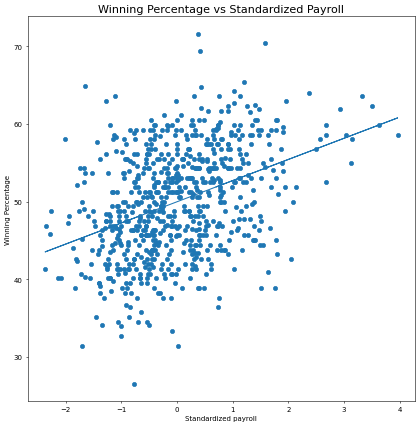

In [44]:
from numpy import polyfit
fig, axs = plt.subplots(1, 1 , figsize = (10, 10), dpi = 50)
# plots the standardized payroll and the win percentages as a scatter plot.
axs.scatter( df["standardized_payroll"], df["win_percentage"])
# gets slope and intercept of regression line using polyfit then plots as a line plot
slope, intercept = polyfit(df["standardized_payroll"], df["win_percentage"], 1)
axs.plot( df["standardized_payroll"], df["standardized_payroll"] * slope + intercept)
# inserts necessary labels for the plot
axs.set_xlabel("Standardized payroll")
axs.set_ylabel("Winning Percentage")
axs.set_title("Winning Percentage vs Standardized Payroll", fontsize=16)

## Code Description 
This code plots the standardized payroll and the win percentages as a scatter plot. It then plots the regression line that best fits it by slope and intercept of regression line using polyfit using the polyfit function from numpy which 

## Problem 8

In [45]:
# calculates difference between actual win percentage and expected percentage predicted by regression line
df["efficiency"] = df["win_percentage"] - (df["standardized_payroll"] * slope + intercept)

/tmp/ipykernel_55965/2543388420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["efficiency"] = df["win_percentage"] - (df["standardized_payroll"] * slope + intercept)


In [46]:
from math import sqrt #  for color picking

Text(0.5, 0, 'Year')

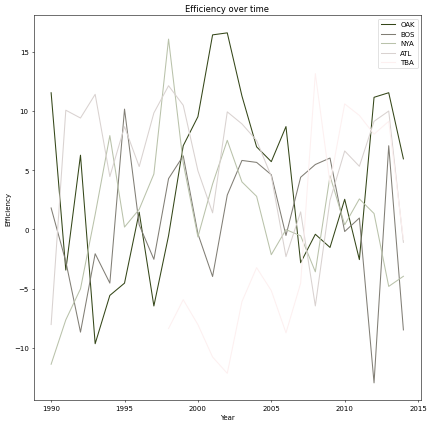

In [47]:
teams = ["OAK", "BOS", "NYA", "ATL", "TBA"] # only looking at these teams
fig, axs = plt.subplots(1, 1 , figsize = (10, 10), dpi = 50)
# plot efficiency and its respective year for each team
for i in range(len(teams)):
    cur_team_df = cur_df[cur_df["teamID"] == teams[i]]
    axs.plot(df.loc[df["teamID"] ==  teams[i], "yearID"],df.loc[df["teamID"] ==  teams[i], "efficiency"], 
             color=tuple([uniform(sqrt(i)/sqrt(len(teams)), (sqrt(i + 1))/sqrt(len(teams))) for x in range(3)]), # color choosen randomly in a way that first few teams are darker than the others
             label = teams[i])
# set graph settings 
axs.legend()
axs.set_title("Efficiency over time")
axs.set_ylabel("Efficiency")
axs.set_xlabel("Year")

## Code Description 
For each of the teams OAK, BOS, NYA, ATL and TBA, the code above plots its efficiency for each year between 1990 and 2014, the efficiency being along the y-axis and its respective year along the x-axis. 

## Question 4
Unlike the set of plots in Question 2 and 3, I can learn whether a team was performing unexpectedly bad or good at a certain year given the standardized payroll for that year (i.e how much the payroll invested for that team differed from other teams that year). I can also see determine whether they've continued to exceed my expectations or do worse than I expected over time. During the Moneyball period, it seems like Oakland's efficiency was pretty positive (pun intended), in fact better than the other 4 teams shown in this plot.

# Extra Credit
## Getting access to recent data
Lahman himself has the most recent data (up until the past 2021 season) at http://www.seanlahman.com/baseball-archive/statistics/. Specifically, he has a csv of all the data at https://github.com/chadwickbureau/baseballdatabank/archive/refs/tags/v2022.2.zip. To access this data, download the zip file and extract it in the same directory as where this ipynb notebook resides. 

## Creating new SQL Database of recent database
Because all of this data are in csv, we can use the to_sql() from pandas to convert each of the csv files in the core,contrib, and upstream folders of the "baseballdatabank-2022.2" folder that's been downloaded. We run the following code ONCE only (since the db file to be used will store the data permanently) :

In [48]:
# import the necessary libraries
import pandas
import os
import sqlite3

In [49]:
"""
Set up a connection; although we don't have a db file, sqlite3.connect will make one for us, essentially making
an empty database. 
We just need to pass in the name we want it to be
(I named it 'ex_credit.db' but any other name with the .db file extension works).
"""
conn = sqlite3.connect("ex_credit.db")

In [50]:
"""
 This function uses pandas to read each csv file under the directories that contain the
 relevant csv files ('baseballdatabank-2022.2/contrib', 'baseballdatabank-2022.2/core', and 
 'baseballdatabank-2022.2/upstream' directories) and convert it to an SQL table that will be inserted into 
 the empty database made in the new db file using the above cell.
"""
def process_dir(dir_name, conn):
    cur_dir = os.path.join(os.getcwd(), dir_name)
    for csv_file in os.listdir(dir_name):
        cur_file = os.path.join(cur_dir, csv_file)
        if os.path.isfile(cur_file):  
            print("Got csv file", csv_file)
            pandas.read_csv(cur_file).to_sql(csv_file.split('.csv')[0], conn, if_exists="append", index=False)

In [51]:
# convert all csv files into SQL tables 
process_dir("baseballdatabank-2022.2/core", conn)
process_dir("baseballdatabank-2022.2/contrib", conn)
process_dir("baseballdatabank-2022.2/upstream", conn)

Got csv file ManagersHalf.csv
Got csv file BattingPost.csv
Got csv file FieldingOF.csv
Got csv file Batting.csv
Got csv file AllstarFull.csv
Got csv file TeamsFranchises.csv
Got csv file Parks.csv
Got csv file Appearances.csv
Got csv file FieldingOFsplit.csv
Got csv file Fielding.csv
Got csv file SeriesPost.csv
Got csv file Managers.csv
Got csv file HomeGames.csv
Got csv file People.csv
Got csv file Teams.csv
Got csv file FieldingPost.csv
Got csv file PitchingPost.csv
Got csv file TeamsHalf.csv
Got csv file Pitching.csv
Got csv file AwardsManagers.csv
Got csv file CollegePlaying.csv
Got csv file HallOfFame.csv
Got csv file AwardsSharePlayers.csv
Got csv file AwardsPlayers.csv
Got csv file Schools.csv
Got csv file Salaries.csv
Got csv file AwardsShareManagers.csv
Got csv file Teams.csv


In [52]:
"""
    We can check to see if all the csv files have been successfully made into SQL tables by listing all
    SQL tables that are present in the database.
"""
pandas.read_sql("SELECT * FROM SQLITE_SCHEMA", conn)

,type,name,tbl_name,rootpage,sql
0,table,ManagersHalf,ManagersHalf,2,"CREATE TABLE ""ManagersHalf"" (\n""playerID"" TEXT..."
1,table,BattingPost,BattingPost,3,"CREATE TABLE ""BattingPost"" (\n""yearID"" INTEGER..."
2,table,FieldingOF,FieldingOF,202,"CREATE TABLE ""FieldingOF"" (\n""playerID"" TEXT,\..."
3,table,Batting,Batting,275,"CREATE TABLE ""Batting"" (\n""playerID"" TEXT,\n ..."
4,table,AllstarFull,AllstarFull,1714,"CREATE TABLE ""AllstarFull"" (\n""playerID"" TEXT,..."
5,table,TeamsFranchises,TeamsFranchises,1772,"CREATE TABLE ""TeamsFranchises"" (\n""franchID"" T..."
6,table,Parks,Parks,1773,"CREATE TABLE ""Parks"" (\n""park.key"" TEXT,\n ""p..."
7,table,Appearances,Appearances,1778,"CREATE TABLE ""Appearances"" (\n""yearID"" INTEGER..."
8,table,FieldingOFsplit,FieldingOFsplit,3135,"CREATE TABLE ""FieldingOFsplit"" (\n""playerID"" T..."
9,table,Fielding,Fielding,3538,"CREATE TABLE ""Fielding"" (\n""playerID"" TEXT,\n ..."
